### 1. Setup and Dependencies

In [1]:
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)
from imblearn.under_sampling import RandomUnderSampler
import optuna
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import joblib
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

### 2. MLflow Configuration

In [3]:
# Set the remote tracking server URI
mlflow.set_tracking_uri("http://ec2-54-211-18-166.compute-1.amazonaws.com:5000/")

# Set or create experiment
mlflow.set_experiment("Experiment 7 - LinearSVC Final Model")


2025/11/12 17:55:10 INFO mlflow.tracking.fluent: Experiment with name 'Experiment 7 - LinearSVC Final Model' does not exist. Creating a new experiment.


<Experiment: artifact_location='s3://mlfow-bucket-2025/790550098221946141', creation_time=1762950309495, experiment_id='790550098221946141', last_update_time=1762950309495, lifecycle_stage='active', name='Experiment 7 - LinearSVC Final Model', tags={}>

### 3. Data Loading 

In [4]:
# Load preprocessed data
df = pd.read_csv('../data/reddit_preprocessing.csv').dropna(subset=['clean_comment'])
print(f"Data shape after cleaning: {df.shape}")

# Fixed configuration from best performing experiment
NGRAM_RANGE = (1, 2)  # Bigram
MAX_FEATURES = 1000
RANDOM_STATE = 42

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    df['clean_comment'], 
    df['category'], 
    test_size=0.2, 
    random_state=RANDOM_STATE, 
    stratify=df['category']
)

# Vectorization using TF-IDF
vectorizer = TfidfVectorizer(ngram_range=NGRAM_RANGE, max_features=MAX_FEATURES)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Apply Undersampling (best method from Experiment 4)
sampler = RandomUnderSampler(random_state=RANDOM_STATE)
X_train_res, y_train_res = sampler.fit_resample(X_train_vec, y_train)

print(f"\nTraining samples after undersampling: {X_train_res.shape[0]}")
print(f"Test samples: {X_test_vec.shape[0]}")
print(f"Feature dimensions: {X_train_res.shape[1]}")

Data shape after cleaning: (36662, 2)

Training samples after undersampling: 19794
Test samples: 7333
Feature dimensions: 1000


### 4. Extensive Hyperparameter Tuning with Optuna

In [5]:
N_TRIALS = 100  # Increased for fine-tuning

def objective_linearsvc(trial):
    """
    Objective function for comprehensive LinearSVC tuning
    """
    # Hyperparameters to tune
    C = trial.suggest_float('C', 0.01, 100.0, log=True)
    loss = trial.suggest_categorical('loss', ['hinge', 'squared_hinge'])
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    
    # Ensure valid combinations (l1 penalty requires dual=False)
    if penalty == 'l1':
        dual = False
    else:
        dual = trial.suggest_categorical('dual', [True, False])
    
    max_iter = trial.suggest_int('max_iter', 1000, 5000, step=1000)
    tol = trial.suggest_float('tol', 1e-5, 1e-3, log=True)
    
    try:
        model = LinearSVC(
            C=C,
            loss=loss,
            penalty=penalty,
            dual=dual,
            max_iter=max_iter,
            tol=tol,
            random_state=RANDOM_STATE,
            class_weight='balanced'
        )
        
        model.fit(X_train_res, y_train_res)
        y_pred = model.predict(X_test_vec)
        
        # Optimize for weighted F1-score
        score = f1_score(y_test, y_pred, average='weighted')
        return score
        
    except Exception as e:
        return 0.0

print("\n" + "="*80)
print(f"Starting Optuna Hyperparameter Tuning ({N_TRIALS} trials)")
print("="*80)

# Create and run study
study = optuna.create_study(
    direction="maximize",
    study_name="LinearSVC_Extensive_Tuning",
    sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE)
)

study.optimize(objective_linearsvc, n_trials=N_TRIALS, show_progress_bar=True)

print(f"\nBest weighted F1-score: {study.best_value:.6f}")
print(f"Best hyperparameters: {study.best_params}")

[I 2025-11-12 17:56:30,518] A new study created in memory with name: LinearSVC_Extensive_Tuning



Starting Optuna Hyperparameter Tuning (100 trials)


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-11-12 17:56:30,587] Trial 0 finished with value: 0.0 and parameters: {'C': 0.31489116479568624, 'loss': 'hinge', 'penalty': 'l1', 'max_iter': 1000, 'tol': 1.3066739238053272e-05}. Best is trial 0 with value: 0.0.
[I 2025-11-12 17:56:32,933] Trial 1 finished with value: 0.7798893844892409 and parameters: {'C': 29.154431891537552, 'loss': 'squared_hinge', 'penalty': 'l2', 'dual': True, 'max_iter': 1000, 'tol': 2.3270677083837777e-05}. Best is trial 1 with value: 0.7798893844892409.
[I 2025-11-12 17:56:32,943] Trial 2 finished with value: 0.0 and parameters: {'C': 0.1648044642797898, 'loss': 'hinge', 'penalty': 'l2', 'dual': False, 'max_iter': 2000, 'tol': 8.168455894760161e-05}. Best is trial 1 with value: 0.7798893844892409.
[I 2025-11-12 17:56:33,127] Trial 3 finished with value: 0.7806579026266008 and parameters: {'C': 13.826232179369875, 'loss': 'squared_hinge', 'penalty': 'l1', 'max_iter': 4000, 'tol': 2.1930485556643678e-05}. Best is trial 3 with value: 0.7806579026266008.


### 5. Train Final Model with Best Parameters

In [6]:
print("\n" + "="*80)
print("TRAINING FINAL MODEL")
print("="*80)

best_params = study.best_params

# Initialize and train final model
final_model = LinearSVC(
    random_state=RANDOM_STATE,
    class_weight='balanced',
    **best_params
)

final_model.fit(X_train_res, y_train_res)
print("Training complete!")



TRAINING FINAL MODEL
Training complete!


### 6. Comprehensive Evaluation

In [7]:
# Make predictions
y_pred = final_model.predict(X_test_vec)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision_macro = precision_score(y_test, y_pred, average='macro')
precision_weighted = precision_score(y_test, y_pred, average='weighted')
recall_macro = recall_score(y_test, y_pred, average='macro')
recall_weighted = recall_score(y_test, y_pred, average='weighted')
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

print("\n--- EVALUATION METRICS ---")
print(f"Accuracy: {accuracy:.6f}")
print(f"Precision (weighted): {precision_weighted:.6f}")
print(f"Recall (weighted): {recall_weighted:.6f}")
print(f"F1-Score (weighted): {f1_weighted:.6f}")

print("\n--- CLASSIFICATION REPORT ---")
print(classification_report(y_test, y_pred, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\n--- CONFUSION MATRIX ---")
print(cm)

# Cross-Validation
print("\n--- CROSS-VALIDATION ---")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
cv_scores = cross_val_score(final_model, X_train_res, y_train_res, cv=cv, scoring='f1_weighted')
print(f"CV F1-Score (weighted): {cv_scores.mean():.6f} (+/- {cv_scores.std() * 2:.6f})")


--- EVALUATION METRICS ---
Accuracy: 0.789990
Precision (weighted): 0.803485
Recall (weighted): 0.789990
F1-Score (weighted): 0.787295

--- CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

          -1     0.7162    0.6515    0.6823      1650
           0     0.7366    0.9589    0.8332      2529
           1     0.9028    0.7270    0.8054      3154

    accuracy                         0.7900      7333
   macro avg     0.7852    0.7791    0.7736      7333
weighted avg     0.8035    0.7900    0.7873      7333


--- CONFUSION MATRIX ---
[[1075  355  220]
 [  77 2425   27]
 [ 349  512 2293]]

--- CROSS-VALIDATION ---
CV F1-Score (weighted): 0.779451 (+/- 0.006199)


### 7. Visualizations


Visualization saved: exp7_linearsvc_evaluation.png


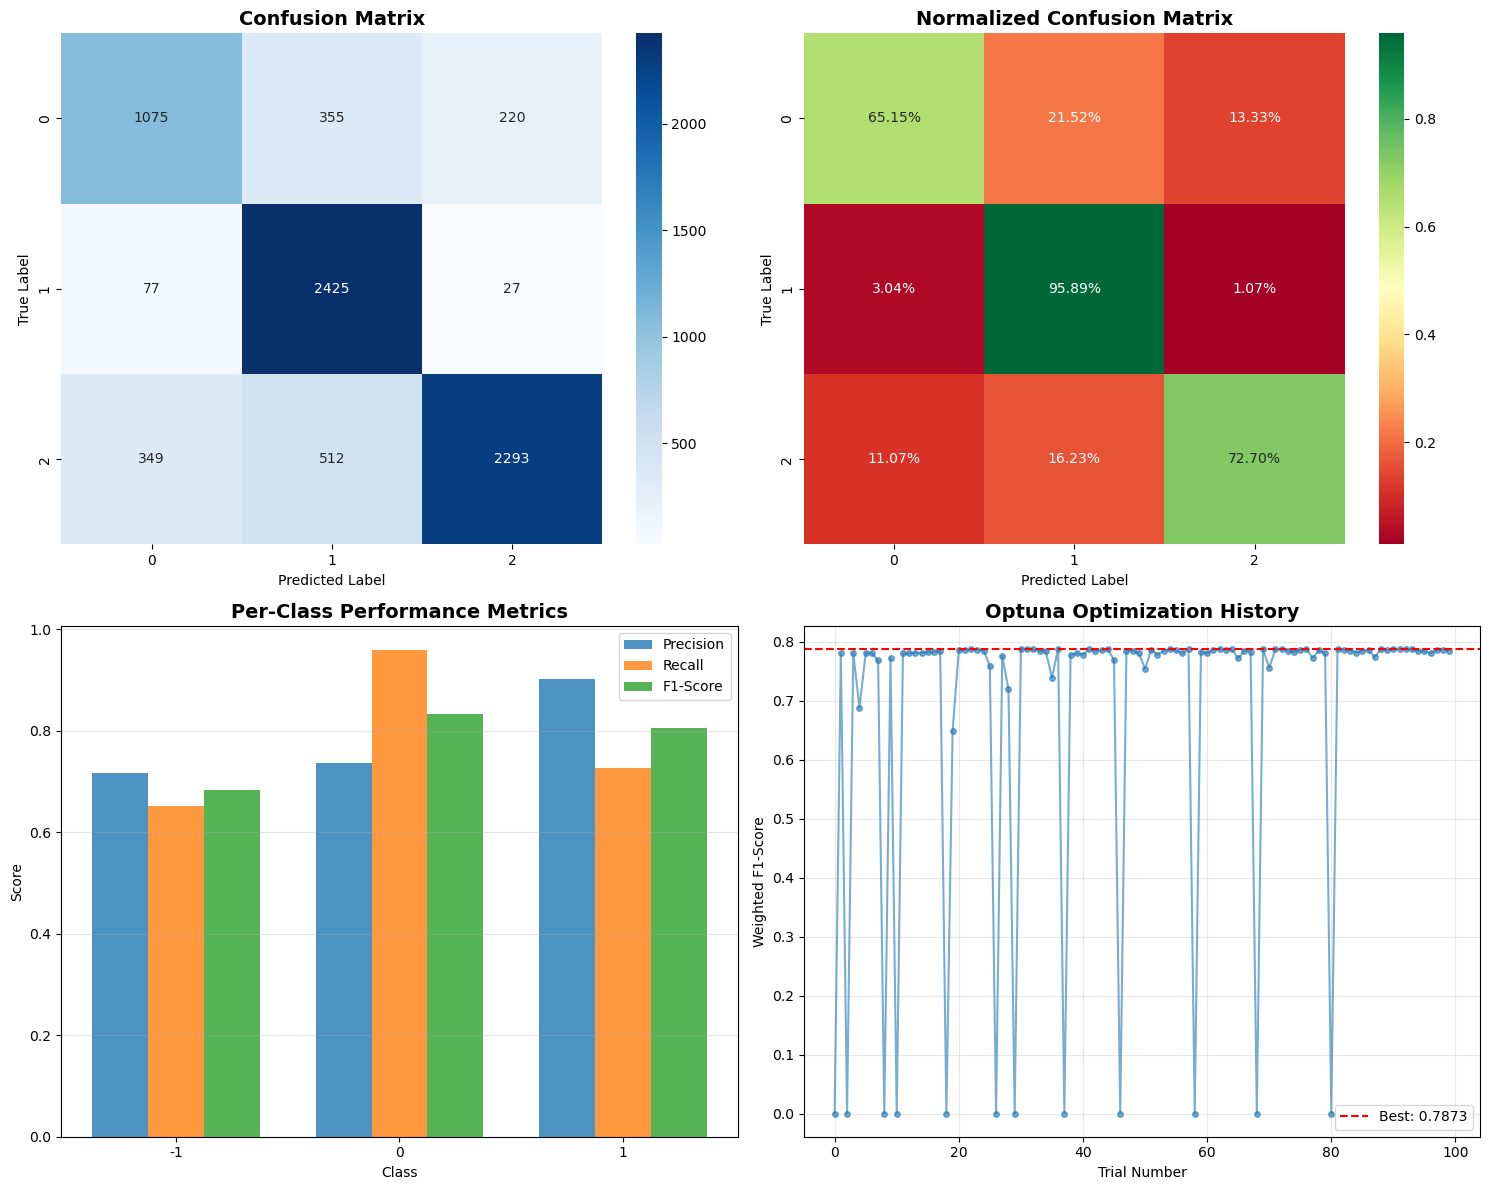

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Confusion Matrix
ax1 = axes[0, 0]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1)
ax1.set_title('Confusion Matrix', fontsize=14, fontweight='bold')
ax1.set_xlabel('Predicted Label')
ax1.set_ylabel('True Label')

# Normalized Confusion Matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
ax2 = axes[0, 1]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='RdYlGn', ax=ax2)
ax2.set_title('Normalized Confusion Matrix', fontsize=14, fontweight='bold')
ax2.set_xlabel('Predicted Label')
ax2.set_ylabel('True Label')

# Per-Class Performance
classes = np.unique(y_test)
precision_per_class = precision_score(y_test, y_pred, average=None)
recall_per_class = recall_score(y_test, y_pred, average=None)
f1_per_class = f1_score(y_test, y_pred, average=None)

ax3 = axes[1, 0]
x = np.arange(len(classes))
width = 0.25
ax3.bar(x - width, precision_per_class, width, label='Precision', alpha=0.8)
ax3.bar(x, recall_per_class, width, label='Recall', alpha=0.8)
ax3.bar(x + width, f1_per_class, width, label='F1-Score', alpha=0.8)
ax3.set_xlabel('Class')
ax3.set_ylabel('Score')
ax3.set_title('Per-Class Performance Metrics', fontsize=14, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(classes)
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# Optuna Optimization History
ax4 = axes[1, 1]
trial_numbers = [t.number for t in study.trials]
trial_values = [t.value for t in study.trials]
ax4.plot(trial_numbers, trial_values, 'o-', alpha=0.6, markersize=4)
ax4.axhline(y=study.best_value, color='r', linestyle='--', label=f'Best: {study.best_value:.4f}')
ax4.set_xlabel('Trial Number')
ax4.set_ylabel('Weighted F1-Score')
ax4.set_title('Optuna Optimization History', fontsize=14, fontweight='bold')
ax4.legend()
ax4.grid(alpha=0.3)

plt.tight_layout()
plot_filename = 'exp7_linearsvc_evaluation.png'
plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
print(f"\nVisualization saved: {plot_filename}")
plt.show()

### 8. Log to MLflow

In [9]:
with mlflow.start_run() as run:
    # Set tags
    mlflow.set_tag("mlflow.runName", "LinearSVC_Final_Model_HPT")
    mlflow.set_tag("experiment_type", "final_model_selection")
    mlflow.set_tag("model_type", "LinearSVC")
    
    # Log preprocessing parameters
    mlflow.log_param("vectorizer_type", "TF-IDF")
    mlflow.log_param("ngram_range", NGRAM_RANGE)
    mlflow.log_param("max_features", MAX_FEATURES)
    mlflow.log_param("imbalance_method", "undersampling")
    mlflow.log_param("n_trials", N_TRIALS)
    mlflow.log_param("random_state", RANDOM_STATE)
    
    # Log best hyperparameters
    for param, value in best_params.items():
        mlflow.log_param(param, value)
    mlflow.log_param("class_weight", "balanced")
    
    # Log overall metrics
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision_macro", precision_macro)
    mlflow.log_metric("precision_weighted", precision_weighted)
    mlflow.log_metric("recall_macro", recall_macro)
    mlflow.log_metric("recall_weighted", recall_weighted)
    mlflow.log_metric("f1_macro", f1_macro)
    mlflow.log_metric("f1_weighted", f1_weighted)
    mlflow.log_metric("cv_f1_mean", cv_scores.mean())
    mlflow.log_metric("cv_f1_std", cv_scores.std())
    
    # Log per-class metrics
    for idx, class_label in enumerate(classes):
        mlflow.log_metric(f"{class_label}_precision", precision_per_class[idx])
        mlflow.log_metric(f"{class_label}_recall", recall_per_class[idx])
        mlflow.log_metric(f"{class_label}_f1-score", f1_per_class[idx])
    
    # Log model
    mlflow.sklearn.log_model(final_model, "final_linearsvc_model")
    
    # Log artifacts
    mlflow.log_artifact(plot_filename)
    
    print("\nSuccessfully logged to MLflow!")
    print(f"Run ID: {run.info.run_id}")


2025/11/12 18:00:25 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/12 18:00:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Successfully logged to MLflow!
Run ID: d7a8326cc86f4f82ba2e24f357cdbe2f
🏃 View run LinearSVC_Final_Model_HPT at: http://ec2-54-211-18-166.compute-1.amazonaws.com:5000/#/experiments/790550098221946141/runs/d7a8326cc86f4f82ba2e24f357cdbe2f
🧪 View experiment at: http://ec2-54-211-18-166.compute-1.amazonaws.com:5000/#/experiments/790550098221946141


### 9. Save Final Model

In [10]:
model_filename = f'final_linearsvc_model_{datetime.now().strftime("%Y%m%d_%H%M%S")}.pkl'
joblib.dump(final_model, model_filename)
print(f"\nModel saved as: {model_filename}")

# Save best parameters
params_filename = f'best_params_{datetime.now().strftime("%Y%m%d_%H%M%S")}.txt'
with open(params_filename, 'w') as f:
    f.write("EXPERIMENT 7: FINAL MODEL SUMMARY\n")
    f.write("="*80 + "\n\n")
    f.write("BEST HYPERPARAMETERS\n")
    f.write("-"*80 + "\n")
    for param, value in best_params.items():
        f.write(f"{param}: {value}\n")
    f.write(f"class_weight: balanced\n")
    f.write("\n")
    f.write("EVALUATION METRICS\n")
    f.write("-"*80 + "\n")
    f.write(f"Accuracy: {accuracy:.6f}\n")
    f.write(f"Weighted F1-Score: {f1_weighted:.6f}\n")
    f.write(f"Weighted Precision: {precision_weighted:.6f}\n")
    f.write(f"Weighted Recall: {recall_weighted:.6f}\n")
    f.write(f"CV F1-Score: {cv_scores.mean():.6f} (+/- {cv_scores.std() * 2:.6f})\n")
    f.write("\n")
    f.write("PER-CLASS METRICS\n")
    f.write("-"*80 + "\n")
    for idx, class_label in enumerate(classes):
        f.write(f"\nClass {class_label}:\n")
        f.write(f"  Precision: {precision_per_class[idx]:.6f}\n")
        f.write(f"  Recall: {recall_per_class[idx]:.6f}\n")
        f.write(f"  F1-Score: {f1_per_class[idx]:.6f}\n")

print(f"Parameters saved as: {params_filename}")


Model saved as: final_linearsvc_model_20251112_180139.pkl
Parameters saved as: best_params_20251112_180139.txt


### 10. Summary

In [11]:
print("\n" + "="*80)
print("EXPERIMENT 7 SUMMARY")
print("="*80)
print(f"Completion Time: {datetime.now()}")
print(f"\nConfiguration:")
print(f"  - Vectorizer: TF-IDF (Bigrams 1-2, max_features=1000)")
print(f"  - Imbalance Handling: Undersampling")
print(f"  - Model: LinearSVC with balanced class weights")
print(f"  - HPT Trials: {N_TRIALS}")
print(f"\nBest Hyperparameters:")
for param, value in best_params.items():
    print(f"  {param}: {value}")
print(f"\nPerformance Metrics:")
print(f"  Test Accuracy: {accuracy:.6f}")
print(f"  Weighted F1-Score: {f1_weighted:.6f}")
print(f"  CV F1-Score: {cv_scores.mean():.6f} (+/- {cv_scores.std() * 2:.6f})")
print("\n" + "="*80)
print("EXPERIMENT COMPLETE!")
print("="*80)


EXPERIMENT 7 SUMMARY
Completion Time: 2025-11-12 18:02:49.419949

Configuration:
  - Vectorizer: TF-IDF (Bigrams 1-2, max_features=1000)
  - Imbalance Handling: Undersampling
  - Model: LinearSVC with balanced class weights
  - HPT Trials: 100

Best Hyperparameters:
  C: 0.23098248082428105
  loss: squared_hinge
  penalty: l1
  max_iter: 1000
  tol: 9.868483511694041e-05

Performance Metrics:
  Test Accuracy: 0.789990
  Weighted F1-Score: 0.787295
  CV F1-Score: 0.779451 (+/- 0.006199)

EXPERIMENT COMPLETE!
